General information
===========

Source (organization): ESnet

Contacts: ESnet (Eric Pouyoul)

Time coverage: 8/1/2015 until 1/16/2016

Features type: TSTAT

Access control: public

Known users: X-SWAP


Overview
=====

This data set consists of [TSTAT](http://tstat.polito.it/) (TCP STatistic and Analysis Tool) data collected at NERSC Data Transfer Nodes (DTNs). The TSTAT tool captures network measurement data for both forward (from NERSC DTN) and backward (to NERSC DTN) stream of packets. TSTAT data is related to the traditional network flow data but differs because it is collected at the source endpoint. Due to this quality, TSTAT data is easier to correlate with other measurements performed on the hosts, such as application logs, I/O etc. The measurement data is collected in a set of text files where each row corresponds to a different flow and each column is associated to a specific measurement. More information about these files and specific measurements can be found [here](http://tstat.tlc.polito.it/measure.shtml#LOG). 



Access
====

The Kibana portal at NERSC can be accessed via the following url (https://kb.nersc.gov). Users need to have a NERSC NIM account to be able to access the data. 

ELK API is available but requires in addition to have access to the cluster:

    . have access to a system (such as a VM) with a static IP.
    . request NERSC to add this IP to the ACL of the cluster.
    . optionally add an SSH tunnel in order to run the Jupyter notebook on your desktop/laptop. 


Data Collection and Visualization
==================

The TSTAT measurement files are created periodically (by default every 5 minutes) on each DTN, and are processed every hour through a client software, [tstat-transport](https://github.com/esnet/tstat-transport), that converts the data into JSON objects and sends them to a RabbitMQ server. There is a [logstash](https://www.elastic.co/guide/en/logstash/current/introduction.html) instance running at NERSC that pulls the data from the RabbitMQ server, calculates additional measurements (like throughput, packets-retransmit% etc.), and ingests them into [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/getting-started.html). NERSC provides a [Kibana](https://www.elastic.co/guide/en/kibana/current/introduction.html) portal to search and visualize the data from Elasticsearch.

In order to visualize TSTAT data, users need to select the appropriate Elasticsearch index, i.e., ** dtn-tstat-20* **. In order to generate graphs, users can click on the * Visualize * option and select the appropriate graph type. Additionally, users can also create a dashboard with a collection of multiple graphs by selecting the * Dashboard * option on the left menu.

If you do not get any result when selecting the dtn-tstat-2017, make sure that the time select is set to several years (top right). You should see something like the picture below:

<img src="tstat-elk-disco-1.png">


The following is a sample of a TSTAT record. A record contains several parts:

    ."meta": contains information related to the source and destination. Note that "sensor_id" contains the DNS name of the host from were the record is from, but src_ip and dst_ip can either be an IPv4, IPv6 or DNS name.
    ."geoip": geographical data of the measurement host
    ."values": contains mostly TCP related measurement
    

    @timestamp
    geoip.city_name
    geoip.continent_code
    geoip.country_code2
    geoip.country_code3
    geoip.country_name
    geoip.dma_code
    geoip.ip
    geoip.latitude
    geoip.location.lat
    geoip.location.lon
    geoip.longitude
    geoip.postal_code
    geoip.region_code
    geoip.region_name
    geoip.timezone

    meta.src_ip
    meta.dst_ip
    meta.dst_port
    meta.flow_type
    meta.instance_id
    meta.protocol
    meta.sensor_id
    meta.src_port

    source
    dest
    start
    end
    interval
    file_size_MB
    num_bytes
    percent_retrans
    throughput_Mbps

    values.bits_per_second
    values.duration
    values.num_bits
    values.num_packets
    values.packets_per_second
    values.tcp_cwin_max
    values.tcp_cwin_min
    values.tcp_initial_cwin
    values.tcp_max_seg_size
    values.tcp_min_seg_size
    values.tcp_mss
    values.tcp_out_seq_pkts
    values.tcp_pkts_dup
    values.tcp_pkts_fc
    values.tcp_pkts_fs
    values.tcp_pkts_reor
    values.tcp_pkts_rto
    values.tcp_pkts_unfs
    values.tcp_pkts_unk
    values.tcp_pkts_unrto
    values.tcp_rexmit_bytes
    values.tcp_rexmit_pkts
    values.tcp_rtt_avg
    values.tcp_rtt_max
    values.tcp_rtt_min
    values.tcp_rtt_std
    values.tcp_sack_cnt

    ndc.amqp_queue
    ndc.index_host
    ndc.index_time
    ndc.system
    ndc.type



Statistical Analysis
===========
In addition to the Kibana visualization, more sophisticated and complex statistical can also be done using the TSTAT data stored in Elasticsearch. We have developed an initial prototype that retrieves the data from Elasticsearch and allows users to perform complex queries and graph analysis on the data. It adds several aggregated columns and cleans the data prior to ingesting it in a MySQL database. This pre-processed data is then used for statistical analysis and building prediction models.

Similar frameworks or tools can be used to do statistical data analysis interactively through the interface. An example is shown below.

#### Sample Interface

Get the RTT values from TSTAT data for some endpoints.

In [1]:
# this is sample code quering the data set
import tstat_analyzer as analyzer

analyzer.get_rtt_values()

Site	Min	Max	StdDev	Avg
-------------------------------------
SLAC	0.001	2.158	0.007	0.006
ANL	47.68	97.985	5.876	54.175
BNL	70.699	110.908	9.996	74.17
ORNL	67.969	107.683	1.138	68.492


Retrieve network performance metrics for some NERSC DTNs.

In [2]:
analyzer.get_metrics()

Site	Tput	Rexmit%	WinScale
-------------------------------------
dtn01	4518.5	63.476	14
dtn05	4358.2	17.632	14
dtn08	6205.1	13.548	14
dtn10	4320.1	12.03	14


Using Jupyter with Elastic
==============


Importing data from ELK into Jupyter
----------------------------------

Since the analytics and visualization is executed within the textbook, data stored in the NERSC ELK cluster need to be accessible to the notebook. There are two methods:

    . Download the result of queries performed on the ELK cluster into files (csv, json). The advantage of this method is that it is simple and allows to share the data with people who do not have access to the cluster. However, it requires manual intervention and therefore it does not scale well. FInally, this method is only acceptable when the data itself is publicaly accessible.
    
    . Use the REST ELK API directely from the notebook. The advantage of this method is that it is possible to write python code that will automate queries. It is also a acceptable method for sharing the result of analytics on restricted data.
    
The following describes both methods.

The query was performed on the ELK Cluster, searching for all flows that were sent from dtn07.nersc.gov. Only a subset of the features were downloaded, namely:

    . 0: meta.src_ip
    . 1: meta.dst_ip
    . 2: start
    . 3: end
    . 4: file_size_MB
    . 5: percent_retrans
    . 6: values.tcp_rtt_min
    . 7: values.tcp_rtt_max
    . 8: values.tcp_rtt_std
    . 9: Max throughput_Mbps

The result was stored in CSV format into the file data/data.csv.

The following code loads the file into the notebook, creating a convenient list of colums.

In [76]:
import csv

def read_data_file():
    with open('data/data.csv') as f:
        first_row = False
        res = []
        for row in csv.reader(f): 
            if not first_row:
                first_row = True
                for col in row:
                    res.append([])
                continue
            index = 0
            for col in row:
                res[index].append(col)
                index += 1
    return res

In [77]:
data = read_data_file()
print "number of columns:",len(data)
print "number of rows:",len(data[0])

number of columns: 10
number of rows: 2175


The second method for importing data requires the notebook to be connected to the NERSC ELK cluster. The following assumes that the notebook is executed by someone who has access to the cluster from a system that is allowed by the cluster ACL's. In this example, the system is a virtual machine, your-vm@your-org. This system will act as a proxy beteen the host running the Jupyter notebook and the cluster. This is done by  establishing an SSH tunnel between:

    ssh your-vm@your-org -N -L 1443:cheshire.nersc.gov:443
    
This creates a tunnel that allows the local host port 1443 to be forwarded to the ELK cluster's port 443.
    
The following Python code is a simple helper for creating such tunnel within this notebook. Note that the code implies that SSH keys are being used for remote connection and does not rely on passwords.

In [3]:
import getpass
import subprocess

def create_tunnel (proxy_host=None,cluster="cheshire.nersc.gov",user=None,local_port=1443,cluster_port=443):
    if proxy_host == None:
        proxy_host = getpass.getpass("proxy host:")
    if user == None:
        user = getpass.getuser()
    args = ["ssh", user + '@' + proxy_host,'-N','-L',str(local_port) + ':' + cluster + ':' + str(cluster_port)]
    p = subprocess.Popen(args=args)
    return p

def kill_tunnel(tunnel):
    tunnel.kill()
    tunnel.wait()
    tunnel.poll()


create_tunnel can fully automate tunnel creation when invoked like:

    tunnel = create_tunnel("myvm@my_org")
    
Note that when publishing your notebook, the name of virtual machine that is used to proxy will be visible. If for security reasons this is not desirable, the function allows to manually enter the proxy_host name hidding its content. Follows such usage. 

In [4]:
tunnel = create_tunnel()

proxy host:········


The tunnel can be stopped using the helper function kill_tunnel:

In [321]:
kill_tunnel(tunnel)

There is currently an issue using the NERSC cluster client through a proxy which hopefully will be resolved, but in the meanwhile, it is necessary for the host running the Jupyter notebook to match the DNS name cheshire.nersc.gov to localhost. On a unix style system, this can be done by adding the line 

127.0.0.1	cheshire.nersc.gov

into the file /etc/hosts.

Any suggestion to improve is welcomed.

Once a tunnel is established, the ELK client can be used. The following helper function connects to the ELK cluster:

In [5]:
# requires elasticsearch (pip install elasticsearch)
import elasticsearch
from requests.utils import DEFAULT_CA_BUNDLE_PATH

def esdb_connect(host="cheshire.nersc.gov",port=1443, ca_certs=None, user=None, password=None):
    if ca_certs == None:
        ca_certs = DEFAULT_CA_BUNDLE_PATH
    if user == None and password == None:
        if user == None:
            user = getpass.getuser()
        password = getpass.getpass(prompt="password: ")
        
    esdb = elasticsearch.Elasticsearch([{
        'host': host,
        'port': port,
        'use_ssl': True,
        'verify_certs': False, 'ca_certs': ca_certs, 'http_auth': (user, password),
    }])
    return esdb

The user is prompted to enter its ELK cluster password. 

If you have been followed this notebook step by step, you will have to re-create the SSH tunnel since it has been killed: tunnel = create_tunnel().

Note, you may see a warning indicating that verify_certs is set to False and is insecure. 

In [6]:
tstat_index = "dtn-tstat-2017*"

esdb = esdb_connect()

password: ········


/anaconda/lib/python2.7/site-packages/elasticsearch/connection/http_urllib3.py:112: UserWarning: Connecting to cheshire.nersc.gov using SSL with verify_certs=False is insecure.
  'Connecting to %s using SSL with verify_certs=False is insecure.' % host)


The ELK cluster client can directly construct DSL queries. For instance, the following searches for measurements from dtn07.nersc.gov.

More information on ELK DSL can be found at https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html

Full reference to the elasticsearch python API can be found at http://elasticsearch-py.readthedocs.io/en/latest/api.html

In [7]:
query={
    "query": {
        "bool": {
            "filter": [
                {"wildcard": {"meta.sensor_id": {"value":"dtn07*"}}}
            ]
        }
    }
}

results = esdb.search(index=tstat_index, body=query, size=10000)
print "total results: ", results['hits']['total']

total results:  253593


Note that the total number of hits is larger than the size of data that was requested, 10,000.

In [198]:
print len(results['hits']['hits'])

10000


Each entry contains the features:

In [23]:
print results['hits']['hits'][9000]

{u'_score': 0.0, u'_type': u'flow', u'_id': u'AV2Z2T6sAhB8fUJVn9GK', u'_source': {u'file_size_MB': 324.51, u'interval': 600, u'end': 1496312852, u'percent_retrans': 0.066, u'start': 1496312815, u'dest': u'dtn07.nersc.gov', u'geoip': {u'region_code': u'CA', u'longitude': -122.2536, u'region_name': u'California', u'country_code2': u'US', u'ip': u'128.55.205.28', u'continent_code': u'NA', u'postal_code': u'94720', u'country_code3': u'US', u'country_name': u'United States', u'city_name': u'Berkeley', u'dma_code': 807, u'latitude': 37.8668, u'timezone': u'America/Los_Angeles', u'location': {u'lat': 37.8668, u'lon': -122.2536}}, u'ndc': {u'amqp_queue': u'ha-dtn-tstat2es5', u'index_time': u'2017-07-31 18:11:53', u'index_host': u'ls5-3', u'type': u'tstat', u'system': u'dtn'}, u'tags': [u'dtn', u'tstat', u'metric', u'ndc'], u'num_bytes': 324506678.0, u'throughput_Mbps': 71.4, u'source': u'ie24.ncsa.illinois.edu', u'meta': {u'sensor_id': u'dtn07.nersc.gov', u'protocol': u'tcp', u'src_ip': u'ie24

Using ELK DSL can become complicated and hard to read. A useful higher level library is provided by elasticsearch-dsl package (https://elasticsearch-dsl.readthedocs.io/en/latest/). This package needs to be installed:

    $ pip install elasticsearch_dsl
    

Processing data in Jupyter
-------------------------

At this point, the data resulting of the query in the memory on the notebook. The structure of the data is a little bit complex and for the sake of simplicity, the JSON format is somewhat flatten, i.e. no nested JSON, and then imported into a pandas DataFrame.

In [59]:
import pandas as pd
from pandas.io.json import read_json

def import_data (json):
    out = []
    def flatten(j,e,name=''):
        if type(j) is dict:
            for a in j:
                if not a in ('_source','values','meta'):
                    flatten(j[a],e, name + a + '_')
                else:
                    flatten(j[a],e, name)
        else:
            e[name[:-1]] = j
                
    for record in json:
        entry = {}
        out.append(entry)
        flatten(record,entry)
    df = pd.DataFrame(out)
    return df

data = import_data(results['hits']['hits'])

data

,@timestamp,@version,_id,_index,_score,_type,bits_per_second,dest,dst_ip,dst_port,...,tcp_rtt_avg,tcp_rtt_max,tcp_rtt_min,tcp_rtt_std,tcp_sack_cnt,tcp_win_max,tcp_win_min,tcp_window_scale,throughput_Mbps,type
0,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaED,dtn-tstat-2017.06.07,0.0,flow,1.020692e+08,NaN,128.55.205.28,50564,...,0.030,71.206,0.001,0.806,397224.0,3009674.0,8.0,7.0,NaN,flow
1,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEK,dtn-tstat-2017.06.07,0.0,flow,9.254953e+07,NaN,128.55.205.28,50203,...,0.026,70.440,0.001,0.785,362517.0,2996788.0,10.0,7.0,NaN,flow
2,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEL,dtn-tstat-2017.06.07,0.0,flow,8.564573e+07,NaN,128.55.205.28,50203,...,0.029,80.434,0.001,0.809,361378.0,3029689.0,10.0,7.0,NaN,flow
3,2017-06-07T18:12:02.012Z,1,AVyDwZsm2A28kEanwTJi,dtn-tstat-2017.06.07,0.0,flow,3.769082e+07,NaN,128.55.205.28,50409,...,0.060,83.878,0.001,1.438,139457.0,2933076.0,4.0,7.0,NaN,flow
4,2017-06-07T17:11:59.738Z,1,AVyDirFqpC3yRFWKg77k,dtn-tstat-2017.06.07,0.0,flow,3.539451e+07,NaN,128.55.205.28,50875,...,0.059,48.577,0.002,1.460,5677.0,2798339.0,38.0,7.0,NaN,flow
5,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch3,dtn-tstat-2017.06.09,0.0,flow,1.222948e+08,NaN,128.55.205.28,50524,...,0.137,39.959,0.001,1.045,0.0,1048644.0,17.0,12.0,NaN,flow
6,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch9,dtn-tstat-2017.06.09,0.0,flow,1.317100e+08,NaN,128.55.205.28,50510,...,0.115,39.970,0.002,0.782,0.0,1647219.0,17.0,12.0,NaN,flow
7,2017-06-09T21:12:03.171Z,1,AVyOsyKMcB_qsvHx2jfv,dtn-tstat-2017.06.09,0.0,flow,1.563694e+08,NaN,128.55.205.28,50101,...,0.181,39.865,0.003,1.650,0.0,2454725.0,17.0,9.0,NaN,flow
8,2017-06-12T03:12:02.670Z,1,AVyaSW8KpC3yRFWKFxW2,dtn-tstat-2017.06.12,0.0,flow,1.673876e+08,NaN,128.55.205.28,50946,...,0.042,70.898,0.001,0.514,114381.0,11001100.0,1.0,12.0,NaN,flow
9,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnt,dtn-tstat-2017.06.12,0.0,flow,1.623105e+08,NaN,140.221.96.52,50258,...,48.118,65.720,47.638,2.458,0.0,12742724.0,17.0,11.0,NaN,flow


Scrolling through the data we can observe that not all records have all the fields filled up or identically. The reason is that the measurements have been made other several years and the agent running on the hosts have been changed over time. In particular:

. dest/source fields where not initially recorded.
. dst_ip and src_ip do not always have a DNS name but an IP address. 
The following function clean up the data. It may take several minutes to process since reverse DNS must be done on some IP addresses that cannot resolve (DNS query timeouts)

In addition, since TSTAT data is mostly interesting on the sender, only file transfers that are sent from NERSC are kept.

In [87]:
from dns import resolver,reversename

#dns_cache={}

def fix_ip(ip):
    global dns_cache
    dns = ip
    if ip in dns_cache:
        return dns_cache[ip]
    try:
        addr=reversename.from_address(ip)
        dns = str(resolver.query(addr,"PTR")[0])[:-1]
    except:
        # not an IP
        pass
    dns_cache[ip] = dns
    return dns

def clean_data(data,drop=False):
    to_drop=[]
    for i in range(len(data)):
        # fix dst/src_ip
        src_ip = fix_ip(data.src_ip[i])
        if drop and not 'nersc.gov' in src_ip:
            #data.drop(i)
            to_drop.append(i)
            continue
        dst_ip = fix_ip(data.dst_ip[i])
        src_ip = fix_ip(data.src_ip[i])
        data.loc[i,'src_ip'] = src_ip
        data.loc[i,'dst_ip'] = dst_ip
        data.loc[i,'source'] = src_ip
        data.loc[i,'dest'] = dst_ip
    if drop:
        res = data
        for i in to_drop:
            res = res.drop(i)
        return res
    return data
    

data=clean_data(data=data, drop=True)

In [88]:
data

,@timestamp,@version,_id,_index,_score,_type,bits_per_second,dest,dst_ip,dst_port,...,tcp_rtt_avg,tcp_rtt_max,tcp_rtt_min,tcp_rtt_std,tcp_sack_cnt,tcp_win_max,tcp_win_min,tcp_window_scale,throughput_Mbps,type
9,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnt,dtn-tstat-2017.06.12,0.0,flow,1.623105e+08,petreldtn2.pub.jlse.anl.gov,petreldtn2.pub.jlse.anl.gov,50258,...,48.118,65.720,47.638,2.458,0.0,12742724.0,17.0,11.0,NaN,flow
10,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnv,dtn-tstat-2017.06.12,0.0,flow,1.435850e+08,petreldtn7.pub.jlse.anl.gov,petreldtn7.pub.jlse.anl.gov,50312,...,47.973,50.767,47.643,0.648,0.0,7570008.0,1.0,11.0,NaN,flow
12,2017-06-13T21:12:03.389Z,1,AVyjTJKaYKR2Ry9V4Cfj,dtn-tstat-2017.06.13,0.0,flow,1.810395e+09,stargrid01.rcf.bnl.gov,stargrid01.rcf.bnl.gov,20886,...,70.898,71.922,70.674,0.211,0.0,16777216.0,1098.0,11.0,NaN,flow
49,2017-06-15T12:12:04.801Z,1,AVyrqu85YKR2Ry9V97DA,dtn-tstat-2017.06.15,0.0,flow,5.265427e+08,ie07.ncsa.illinois.edu,ie07.ncsa.illinois.edu,50372,...,53.887,103.955,52.635,0.835,0.0,22924776.0,38.0,11.0,NaN,flow
50,2017-06-15T12:12:04.801Z,1,AVyrqu85YKR2Ry9V97DC,dtn-tstat-2017.06.15,0.0,flow,5.217261e+08,ie07.ncsa.illinois.edu,ie07.ncsa.illinois.edu,50372,...,53.893,105.923,52.645,0.797,0.0,19103980.0,38.0,11.0,NaN,flow
54,2017-06-15T16:11:56.972Z,1,AVyshqXaYKR2Ry9V_Vxv,dtn-tstat-2017.06.15,0.0,flow,2.695097e+08,data1.stampede2.tacc.utexas.edu,data1.stampede2.tacc.utexas.edu,50220,...,57.896,140.480,45.528,14.763,3316.0,8388608.0,1.0,11.0,NaN,flow
59,2017-06-15T19:12:03.317Z,1,AVytK22QpC3yRFWKMdFu,dtn-tstat-2017.06.15,0.0,flow,1.787487e+08,petreldtn5.pub.jlse.anl.gov,petreldtn5.pub.jlse.anl.gov,50165,...,54.331,94.975,47.638,8.865,0.0,12903016.0,1.0,11.0,NaN,flow
60,2017-06-15T20:11:55.493Z,1,AVytYlqM2A28kEandmXC,dtn-tstat-2017.06.15,0.0,flow,1.163138e+08,petreldtn4.pub.jlse.anl.gov,petreldtn4.pub.jlse.anl.gov,50216,...,50.138,87.209,47.651,6.947,0.0,5784774.0,17.0,11.0,NaN,flow
61,2017-06-15T20:11:55.493Z,1,AVytYlqN2A28kEandmbC,dtn-tstat-2017.06.15,0.0,flow,1.117961e+08,petreldtn4.pub.jlse.anl.gov,petreldtn4.pub.jlse.anl.gov,50216,...,50.137,87.827,47.574,6.268,0.0,5798088.0,38.0,11.0,NaN,flow
62,2017-06-15T20:11:55.493Z,1,AVytYlqN2A28kEandmb7,dtn-tstat-2017.06.15,0.0,flow,1.128572e+08,petreldtn4.pub.jlse.anl.gov,petreldtn4.pub.jlse.anl.gov,50216,...,49.460,87.177,47.573,5.218,0.0,5896732.0,17.0,11.0,NaN,flow


Data is now cleaned up. Any python packages that can be used. Jupyter comes bbundled with commonly used packages.

The following displays the throughput in for each file transfer

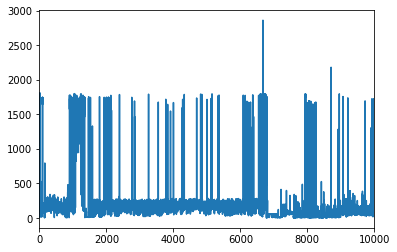

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
(data.bits_per_second/1000000).plot()
plt.show()



In [46]:
data

,@timestamp,@version,_id,_index,_score,_type,bits_per_second,dest,dst_ip,dst_port,...,tcp_rtt_avg,tcp_rtt_max,tcp_rtt_min,tcp_rtt_std,tcp_sack_cnt,tcp_win_max,tcp_win_min,tcp_window_scale,throughput_Mbps,type
0,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaED,dtn-tstat-2017.06.07,0.0,flow,1.020692e+08,dtn07.nersc.gov,dtn07.nersc.gov,50564,...,0.030,71.206,0.001,0.806,397224.0,3009674.0,8.0,7.0,NaN,flow
1,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEK,dtn-tstat-2017.06.07,0.0,flow,9.254953e+07,dtn07.nersc.gov,dtn07.nersc.gov,50203,...,0.026,70.440,0.001,0.785,362517.0,2996788.0,10.0,7.0,NaN,flow
2,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEL,dtn-tstat-2017.06.07,0.0,flow,8.564573e+07,dtn07.nersc.gov,dtn07.nersc.gov,50203,...,0.029,80.434,0.001,0.809,361378.0,3029689.0,10.0,7.0,NaN,flow
3,2017-06-07T18:12:02.012Z,1,AVyDwZsm2A28kEanwTJi,dtn-tstat-2017.06.07,0.0,flow,3.769082e+07,dtn07.nersc.gov,dtn07.nersc.gov,50409,...,0.060,83.878,0.001,1.438,139457.0,2933076.0,4.0,7.0,NaN,flow
4,2017-06-07T17:11:59.738Z,1,AVyDirFqpC3yRFWKg77k,dtn-tstat-2017.06.07,0.0,flow,3.539451e+07,dtn07.nersc.gov,dtn07.nersc.gov,50875,...,0.059,48.577,0.002,1.460,5677.0,2798339.0,38.0,7.0,NaN,flow
5,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch3,dtn-tstat-2017.06.09,0.0,flow,1.222948e+08,dtn07.nersc.gov,dtn07.nersc.gov,50524,...,0.137,39.959,0.001,1.045,0.0,1048644.0,17.0,12.0,NaN,flow
6,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch9,dtn-tstat-2017.06.09,0.0,flow,1.317100e+08,dtn07.nersc.gov,dtn07.nersc.gov,50510,...,0.115,39.970,0.002,0.782,0.0,1647219.0,17.0,12.0,NaN,flow
7,2017-06-09T21:12:03.171Z,1,AVyOsyKMcB_qsvHx2jfv,dtn-tstat-2017.06.09,0.0,flow,1.563694e+08,dtn07.nersc.gov,dtn07.nersc.gov,50101,...,0.181,39.865,0.003,1.650,0.0,2454725.0,17.0,9.0,NaN,flow
8,2017-06-12T03:12:02.670Z,1,AVyaSW8KpC3yRFWKFxW2,dtn-tstat-2017.06.12,0.0,flow,1.673876e+08,dtn07.nersc.gov,dtn07.nersc.gov,50946,...,0.042,70.898,0.001,0.514,114381.0,11001100.0,1.0,12.0,NaN,flow
9,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnt,dtn-tstat-2017.06.12,0.0,flow,1.623105e+08,petreldtn2.pub.jlse.anl.gov,petreldtn2.pub.jlse.anl.gov,50258,...,48.118,65.720,47.638,2.458,0.0,12742724.0,17.0,11.0,NaN,flow


In [47]:
data.drop(0)

,@timestamp,@version,_id,_index,_score,_type,bits_per_second,dest,dst_ip,dst_port,...,tcp_rtt_avg,tcp_rtt_max,tcp_rtt_min,tcp_rtt_std,tcp_sack_cnt,tcp_win_max,tcp_win_min,tcp_window_scale,throughput_Mbps,type
1,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEK,dtn-tstat-2017.06.07,0.0,flow,9.254953e+07,dtn07.nersc.gov,dtn07.nersc.gov,50203,...,0.026,70.440,0.001,0.785,362517.0,2996788.0,10.0,7.0,NaN,flow
2,2017-06-07T12:12:02.165Z,1,AVyCeAPCcB_qsvHxPaEL,dtn-tstat-2017.06.07,0.0,flow,8.564573e+07,dtn07.nersc.gov,dtn07.nersc.gov,50203,...,0.029,80.434,0.001,0.809,361378.0,3029689.0,10.0,7.0,NaN,flow
3,2017-06-07T18:12:02.012Z,1,AVyDwZsm2A28kEanwTJi,dtn-tstat-2017.06.07,0.0,flow,3.769082e+07,dtn07.nersc.gov,dtn07.nersc.gov,50409,...,0.060,83.878,0.001,1.438,139457.0,2933076.0,4.0,7.0,NaN,flow
4,2017-06-07T17:11:59.738Z,1,AVyDirFqpC3yRFWKg77k,dtn-tstat-2017.06.07,0.0,flow,3.539451e+07,dtn07.nersc.gov,dtn07.nersc.gov,50875,...,0.059,48.577,0.002,1.460,5677.0,2798339.0,38.0,7.0,NaN,flow
5,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch3,dtn-tstat-2017.06.09,0.0,flow,1.222948e+08,dtn07.nersc.gov,dtn07.nersc.gov,50524,...,0.137,39.959,0.001,1.045,0.0,1048644.0,17.0,12.0,NaN,flow
6,2017-06-09T19:12:05.072Z,1,AVyORU12cB_qsvHx4ch9,dtn-tstat-2017.06.09,0.0,flow,1.317100e+08,dtn07.nersc.gov,dtn07.nersc.gov,50510,...,0.115,39.970,0.002,0.782,0.0,1647219.0,17.0,12.0,NaN,flow
7,2017-06-09T21:12:03.171Z,1,AVyOsyKMcB_qsvHx2jfv,dtn-tstat-2017.06.09,0.0,flow,1.563694e+08,dtn07.nersc.gov,dtn07.nersc.gov,50101,...,0.181,39.865,0.003,1.650,0.0,2454725.0,17.0,9.0,NaN,flow
8,2017-06-12T03:12:02.670Z,1,AVyaSW8KpC3yRFWKFxW2,dtn-tstat-2017.06.12,0.0,flow,1.673876e+08,dtn07.nersc.gov,dtn07.nersc.gov,50946,...,0.042,70.898,0.001,0.514,114381.0,11001100.0,1.0,12.0,NaN,flow
9,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnt,dtn-tstat-2017.06.12,0.0,flow,1.623105e+08,petreldtn2.pub.jlse.anl.gov,petreldtn2.pub.jlse.anl.gov,50258,...,48.118,65.720,47.638,2.458,0.0,12742724.0,17.0,11.0,NaN,flow
10,2017-06-12T18:11:58.999Z,1,AVydgWjVJ-ncjoJBJAnv,dtn-tstat-2017.06.12,0.0,flow,1.435850e+08,petreldtn7.pub.jlse.anl.gov,petreldtn7.pub.jlse.anl.gov,50312,...,47.973,50.767,47.643,0.648,0.0,7570008.0,1.0,11.0,NaN,flow


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def sort_by_destination(data):
    nb_cols = len(data)
    res = {}
    index = 0
    for dst in data[1]:
        if not dst in res:
            res[dst] = []
            for i in range(nb_cols):
                res[dst].append([])
                
        for col in range(nb_cols):
            res[dst][col].append(data[col][index])
        index += 1
    return res


In [33]:
by_dest = sort_by_destination(data)
print "number of destinations:", len(by_dest)

number of destinations: 165


<IPython.core.display.Javascript object>


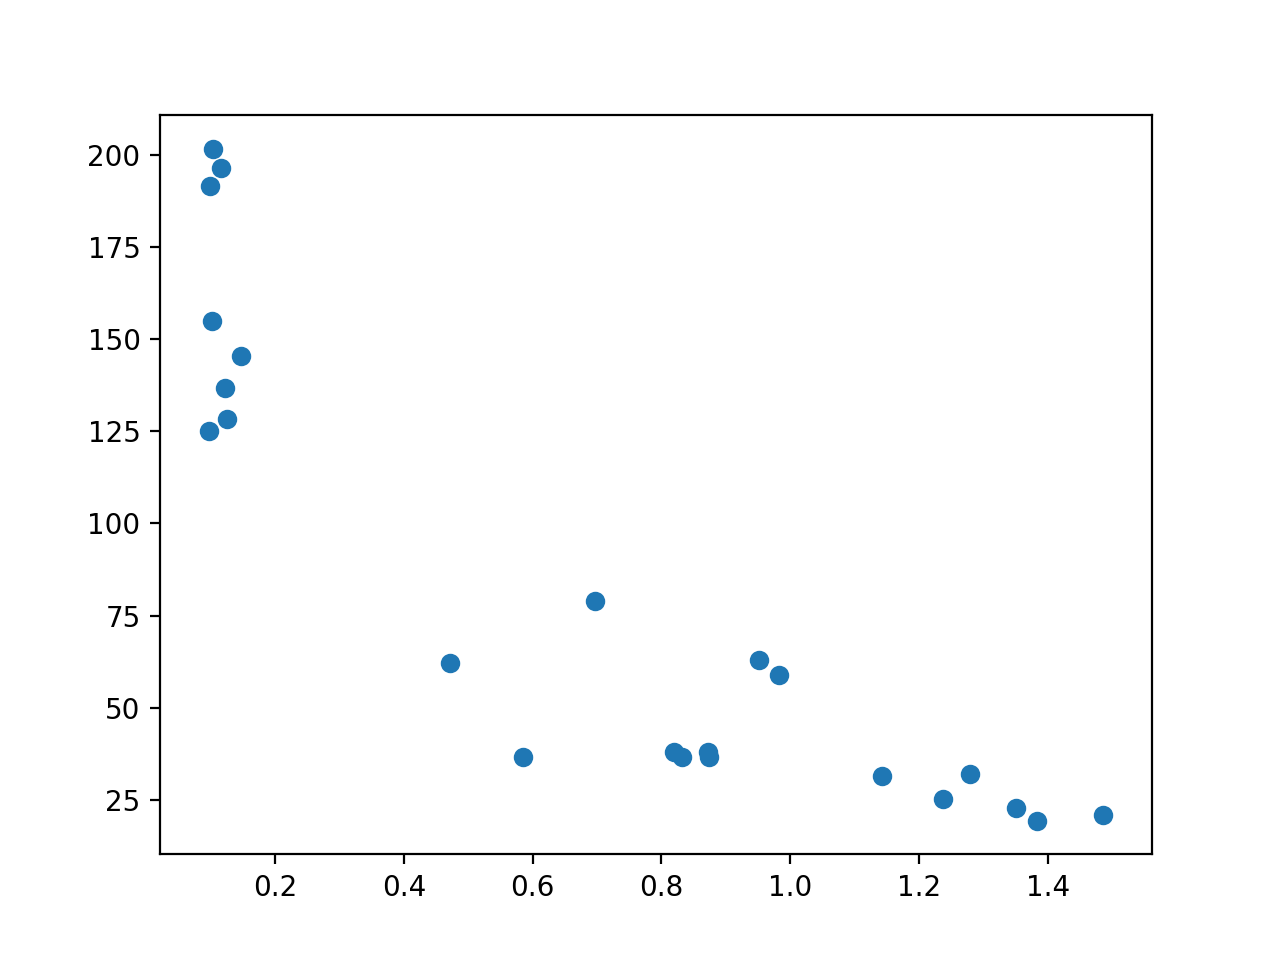

In [34]:
# needs  $ conda install -c conda-forge bqplot
%gui osx
%matplotlib notebook
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt

import bqplot.pyplot as bplt
from bqplot import LinearScale
from bqplot import Axis

def plot_dest(row, dest, x_index, y_index):
    plot = plt.scatter(row[x_index],row[y_index],label=dest)
    return plot

plot = plot_dest(by_dest['gridftp01.ucar.edu'],'gridftp01.ucar.edu',5,9)
#plt.show()

Results, issues, filtering, pre-processing
=======================

It is important to note that TSTAT data is mostly useful if collected at the source of the flows. In other words, data that are received from other DTN can be filtered out.
